In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/favorita-grocery-sales-forecasting/test.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/stores.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/items.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/holidays_events.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/transactions.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/train.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/oil.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/sample_submission.csv.7z


In [2]:
# Cài đặt giải nén file csv.7z
!pip -q install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.5/99.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 24.7 MB/s eta 0:00:00


In [3]:
# Import thư viện cần thiết
import pandas as pd
import numpy as np
import warnings
import py7zr
import os, gc
import re
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl
import sys
from IPython import get_ipython
import torch
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [4]:
# Danh sách các file CSV muốn giải nén
files_to_extract = [
    'train.csv',
    'transactions.csv',
    'stores.csv',
    'oil.csv',
    'items.csv',
    'holidays_events.csv'
]

# Thư mục đích để giải nén
extract_path = "/kaggle/working"
os.makedirs(extract_path, exist_ok=True) # Đảm bảo thư mục đích tồn tại

print("Bắt đầu giải nén các file được chọn...")

for dirname, _, filenames in os.walk('/kaggle/input/favorita-grocery-sales-forecasting'):
    for filename in filenames:
        archive_path = os.path.join(dirname, filename)
        try:
            # Mở file 7z
            with py7zr.SevenZipFile(archive_path, mode='r') as archive:
                # Lặp qua các file muốn giải nén
                for file_to_extract in files_to_extract:
                    print(f"  Đang giải nén: {file_to_extract}")
                    # Sử dụng extract() để chỉ giải nén file mong muốn
                    archive.extract(path=extract_path, targets=[file_to_extract])

            print("Giải nén hoàn tất các file được chọn.")

        except py7zr.Bad7zFile:
            print(f"Lỗi: File {filename} không phải là file 7z hợp lệ hoặc bị hỏng.")
        except FileNotFoundError:
            print(f"Lỗi: Không tìm thấy file {archive_path}.")
        except Exception as e:
            print(f"Đã xảy ra lỗi: {e}")


# Kiểm tra lại các file đã được giải nén trong thư mục working
print("\n--- Danh sách file trong thư mục 'working' ---")
# Sử dụng 'ls -l' để hiển thị chi tiết hơn
print(check_output(["ls", "-l", "../working"]).decode("utf8"))

Bắt đầu giải nén các file được chọn...
  Đang giải nén: train.csv
  Đang giải nén: transactions.csv
  Đang giải nén: stores.csv
  Đang giải nén: oil.csv
  Đang giải nén: items.csv
  Đang giải nén: holidays_events.csv
Giải nén hoàn tất các file được chọn.
  Đang giải nén: train.csv
  Đang giải nén: transactions.csv
  Đang giải nén: stores.csv
  Đang giải nén: oil.csv
  Đang giải nén: items.csv
  Đang giải nén: holidays_events.csv
Giải nén hoàn tất các file được chọn.
  Đang giải nén: train.csv
  Đang giải nén: transactions.csv
  Đang giải nén: stores.csv
  Đang giải nén: oil.csv
  Đang giải nén: items.csv
  Đang giải nén: holidays_events.csv
Giải nén hoàn tất các file được chọn.
  Đang giải nén: train.csv
  Đang giải nén: transactions.csv
  Đang giải nén: stores.csv
  Đang giải nén: oil.csv
  Đang giải nén: items.csv
  Đang giải nén: holidays_events.csv
Giải nén hoàn tất các file được chọn.
  Đang giải nén: train.csv
  Đang giải nén: transactions.csv
  Đang giải nén: stores.csv
  Đang g

# Cắt bỏ dữ liệu chỉ giữ năm 2016-2017 để phân tích

In [5]:
# Hàm hỗ trợ để đọc, chuyển đổi ngày và lọc dữ liệu
def prune_data(filename, chunksize=5_000_000):
    """
    Đọc file CSV theo từng chunk, lọc ngay các bản ghi năm 2016-2017 
    để bộ nhớ RAM không bao giờ bị quá tải.
    """
    print(f"Stream loading & pruning: {filename}...")
    
    filtered_chunks = []
    
    # parse_dates=['date'] giúp Pandas hiểu cột ngày tháng ngay khi đọc
    # chunksize chia file lớn thành các phần nhỏ (ví dụ 5 triệu dòng/lần)
    reader = pd.read_csv(filename, parse_dates=['date'], chunksize=chunksize, low_memory=False)
    
    for chunk in reader:
        # Lọc ngay lập tức trên từng mảnh nhỏ
        chunk_filtered = chunk[chunk['date'].dt.year.isin([2016, 2017])]
        
        # Chỉ giữ lại phần dữ liệu thỏa mãn điều kiện
        if not chunk_filtered.empty:
            filtered_chunks.append(chunk_filtered)
    
    # Gộp các mảnh đã lọc lại thành 1 DataFrame hoàn chỉnh
    if len(filtered_chunks) > 0:
        df_pruned = pd.concat(filtered_chunks, ignore_index=True)
    else:
        # Trường hợp không có dữ liệu nào khớp (trả về DF rỗng có cấu trúc đúng)
        header = pd.read_csv(filename, nrows=0)
        df_pruned = pd.DataFrame(columns=header.columns)
        if 'date' in df_pruned.columns:
            df_pruned['date'] = pd.to_datetime(df_pruned['date'])

    # Giải phóng biến trung gian ngay lập tức
    del filtered_chunks
    gc.collect()
    
    return df_pruned

In [6]:
# 1. train.csv
train_pruned = prune_data("train.csv")
print(f"train_pruned: {len(train_pruned)} bản ghi đã được tải (2016-2017).")

# 2. transactions.csv
transactions_pruned = prune_data("transactions.csv")
print(f"transactions_pruned: {len(transactions_pruned)} bản ghi đã được tải (2016-2017).")

# 3. oil.csv
oil_pruned = prune_data("oil.csv")
print(f"oil_pruned: {len(oil_pruned)} bản ghi đã được tải (2016-2017).")

# 4. holidays_events.csv
holidays_pruned = prune_data("holidays_events.csv")
print(f"holidays_pruned: {len(holidays_pruned)} bản ghi đã được tải (2016-2017).")

print("\nĐã lọc và lưu toàn bộ dữ liệu năm 2016-2017 thành công!")

Stream loading & pruning: train.csv...
train_pruned: 59038132 bản ghi đã được tải (2016-2017).
Stream loading & pruning: transactions.csv...
transactions_pruned: 31096 bản ghi đã được tải (2016-2017).
Stream loading & pruning: oil.csv...
oil_pruned: 435 bản ghi đã được tải (2016-2017).
Stream loading & pruning: holidays_events.csv...
holidays_pruned: 139 bản ghi đã được tải (2016-2017).

Đã lọc và lưu toàn bộ dữ liệu năm 2016-2017 thành công!


In [7]:
# Kiểm tra
print("Kiểm tra 5 dòng đầu tâp train")
print(train_pruned.head())

print("\nKiểm tra 5 dòng đầu của transactions")
print(transactions_pruned.head())

print("\nKiểm tra 5 dòng đầu của oil")
print(oil_pruned.head())

print("\nKiểm tra 5 dòng đầu của holidays_events")
print(holidays_pruned.head())

Kiểm tra 5 dòng đầu tâp train
         id       date  store_nbr  item_nbr  unit_sales  onpromotion
0  66458908 2016-01-01         25    105574        12.0        False
1  66458909 2016-01-01         25    105575         9.0        False
2  66458910 2016-01-01         25    105857         3.0        False
3  66458911 2016-01-01         25    108634         3.0        False
4  66458912 2016-01-01         25    108701         2.0         True

Kiểm tra 5 dòng đầu của transactions
        date  store_nbr  transactions
0 2016-01-02          2             6
1 2016-01-02         16           373
2 2016-01-02         20          1816
3 2016-01-02         21          1388
4 2016-01-02         22           849

Kiểm tra 5 dòng đầu của oil
        date  dcoilwtico
0 2016-01-01         NaN
1 2016-01-04       36.81
2 2016-01-05       35.97
3 2016-01-06       33.97
4 2016-01-07       33.29

Kiểm tra 5 dòng đầu của holidays_events
        date     type    locale locale_name         des

# Tiền xử lý dữ liệu

## Các hàm tiện ích

In [8]:
def check_null(df: pd.DataFrame) -> dict:
    """Trả về số lượng giá trị null theo từng cột (Pandas) dưới dạng dict."""
    return df.isnull().sum().to_dict()

def check_duplicate(df: pd.DataFrame) -> int:
    """
    Trả về tổng số dòng trùng lặp trong DataFrame (Pandas).
    """
    dup_count = df.duplicated().sum()
    print(f"Số dòng trùng lặp: {dup_count}")
    return dup_count
    
def check_negative(df: pd.DataFrame) -> dict:
    """
    Trả về tổng số giá trị âm trong từng cột số (dưới dạng dict).
    """
    # Lọc danh sách cột kiểu số (integer/float)
    numeric_df = df.select_dtypes(include=np.number)
    return (numeric_df < 0).sum().to_dict()

def check_strange_char(df: pd.DataFrame, pattern=r"[^a-zA-Z0-9\s.,:/\-_]") -> dict:
    """
    Kiểm tra số lượng giá trị chứa ký tự lạ (ngoài chữ,số,khoảng trắng và vài dấu cơ bản) trong các cột chuỗi.
    (Phiên bản đã sửa lỗi)
    """
    # Lọc danh sách cột kiểu chuỗi (object)
    str_cols = df.select_dtypes(include='object').columns.tolist()
    results = {}

    for c in str_cols:
        try:
            count = int(df[c].astype(str).str.contains(pattern).sum())
            results[c] = count
        except Exception as e:
            print(f"Không thể xử lý cột '{c}': {e}")
            results[c] = 0

    return results

# Tạo feature về thời gian (season)- mùa trong năm
def season_from_month(m):
    if m in [12, 1, 2]: return 0  # Winter
    elif m in [3, 4, 5]: return 1  # Spring
    elif m in [6, 7, 8]: return 2  # Summer
    else: return 3  # Fall

# Check các biến không sử dụng gây tốn RAM
def check_memory_usage(n_top=20):
    """
    Hàm kiểm tra các biến toàn cục (global vars) đang chiếm bao nhiêu RAM.
    """
    # Lấy tất cả biến trong môi trường global
    gl = globals()
    
    vars_info = []
    
    for var_name in gl:
        # Bỏ qua các biến hệ thống (bắt đầu bằng _) và các module imports
        if not var_name.startswith('_') and var_name not in ['In', 'Out', 'get_ipython', 'exit', 'quit']:
            value = gl[var_name]
            
            # Tính kích thước (bytes)
            try:
                # Nếu là DataFrame/Series thì dùng memory_usage(deep=True) chuẩn hơn
                if hasattr(value, 'memory_usage'):
                    if isinstance(value, pd.DataFrame):
                        size = value.memory_usage(deep=True).sum()
                    else:
                        size = value.memory_usage(deep=True)
                else:
                    size = sys.getsizeof(value)
                
                vars_info.append((var_name, size))
            except:
                pass # Bỏ qua nếu không tính được size
                
    # Sắp xếp giảm dần theo size
    vars_info.sort(key=lambda x: x[1], reverse=True)
    
    print(f"{'Variable Name':<25} | {'Size (MB)':<10} | {'Type'}")
    print("-" * 50)
    
    total_tracked = 0
    for name, size in vars_info[:n_top]:
        size_mb = size / (1024 ** 2)
        total_tracked += size_mb
        # Lấy type của biến
        dtype = type(gl[name]).__name__
        print(f"{name:<25} | {size_mb:>10.2f} | {dtype}")
        
    print("-" * 50)
    print(f"Total tracked memory (Top {n_top}): {total_tracked:.2f} MB")

# --- CHẠY HÀM ---
check_memory_usage()

Variable Name             | Size (MB)  | Type
--------------------------------------------------
train_pruned              |    2308.43 | DataFrame
transactions_pruned       |       0.71 | DataFrame
holidays_pruned           |       0.04 | DataFrame
oil_pruned                |       0.01 | DataFrame
check_output              |       0.00 | function
prune_data                |       0.00 | function
check_null                |       0.00 | function
check_duplicate           |       0.00 | function
check_negative            |       0.00 | function
check_strange_char        |       0.00 | function
season_from_month         |       0.00 | function
check_memory_usage        |       0.00 | function
archive_path              |       0.00 | str
filenames                 |       0.00 | list
files_to_extract          |       0.00 | list
dirname                   |       0.00 | str
filename                  |       0.00 | str
np                        |       0.00 | module
pd                      

## Tiền xử lý tập train_pruned

In [9]:
train_pruned.shape

(59038132, 6)

In [10]:
# Kiểm tra null
print("Tổng số giá trị null: ", check_null(train_pruned))

# Kiểm tra trùng lặp
print("Tổng số giá trị trùng lặp: ", check_duplicate(train_pruned))

# Kiểm tra giá trị âm
print("Tổng số giá trị âm: ", check_negative(train_pruned))

# Kiểm tra giá trị có ký tự đặc biệt
print("Tổng số giá trị có ký tự đăc biệt: ", check_strange_char(train_pruned))

Tổng số giá trị null:  {'id': 0, 'date': 0, 'store_nbr': 0, 'item_nbr': 0, 'unit_sales': 0, 'onpromotion': 0}
Số dòng trùng lặp: 0
Tổng số giá trị trùng lặp:  0
Tổng số giá trị âm:  {'id': 0, 'store_nbr': 0, 'item_nbr': 0, 'unit_sales': 3879}
Tổng số giá trị có ký tự đăc biệt:  {}


In [11]:
# Xử lý giá trị < 0 trong unit_sales
negative_before = (train_pruned['unit_sales'] < 0).sum()
print(f"Số giá trị 'unit_sales' âm (trước khi sửa): {negative_before}")

# Một số dòng có unit_sales < 0 → thay bằng 0 đại diện cho không bán được
train_pruned['unit_sales'] = train_pruned['unit_sales'].clip(lower=0)

# --- Kiểm tra lại kết quả ---
negative_after = (train_pruned['unit_sales'] < 0).sum()
print(f"Số giá trị 'unit_sales' < 0 (sau khi sửa): {negative_after}")

if negative_after == 0:
    print("Đã cập nhật thành công: Tất cả giá trị < 0 trong 'unit_sales' đã được đổi thành 0")
else:
    print("Lỗi: Vẫn còn giá trị <= 0")

Số giá trị 'unit_sales' âm (trước khi sửa): 3879
Số giá trị 'unit_sales' < 0 (sau khi sửa): 0
Đã cập nhật thành công: Tất cả giá trị < 0 trong 'unit_sales' đã được đổi thành 0


In [12]:
print("Tổng số giá trị âm: ", check_negative(train_pruned))

Tổng số giá trị âm:  {'id': 0, 'store_nbr': 0, 'item_nbr': 0, 'unit_sales': 0}


Đang tạo boxplot cho cột: id...
Đang tạo boxplot cho cột: store_nbr...
Đang tạo boxplot cho cột: item_nbr...
Đang tạo boxplot cho cột: unit_sales...


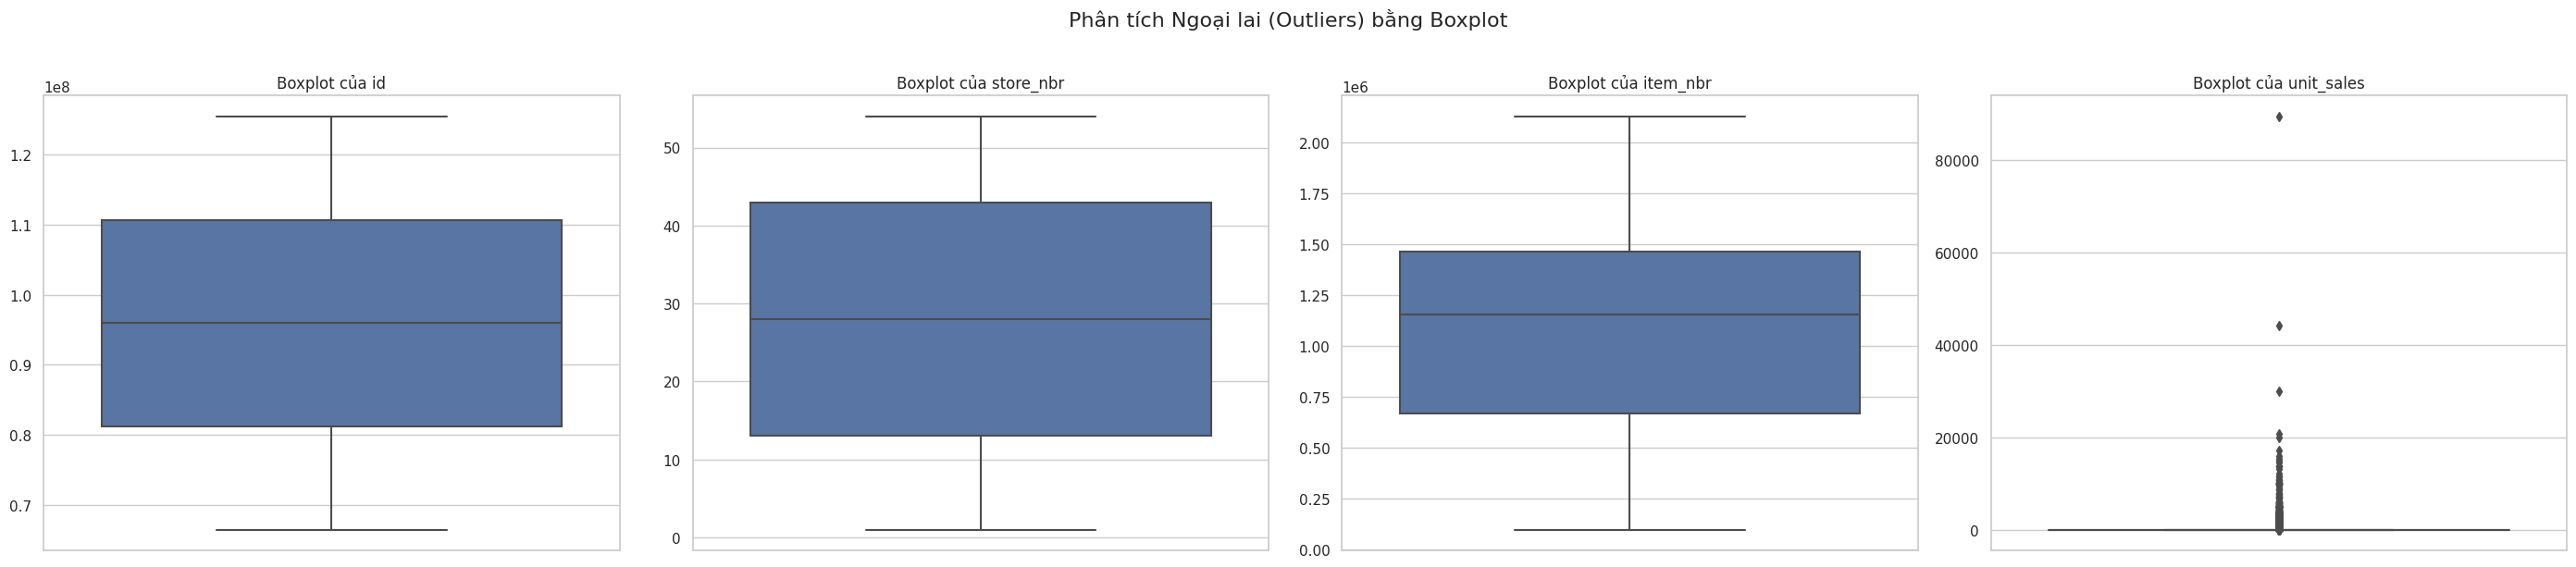

In [13]:
# Trực quan dữ liệu để kiểm tra outlier
sns.set_theme(style="whitegrid")

# Danh sách các cột kiểm tra outlier
cols_to_plot = ['id', 'store_nbr', 'item_nbr', 'unit_sales']

n_features = len(cols_to_plot)

# Vẽ Boxplot
fig, axes = plt.subplots(nrows=1, ncols=n_features, figsize=(7 * n_features, 6))

# Đặt tiêu đề chung cho tất cả biểu đồ
fig.suptitle('Phân tích Ngoại lai (Outliers) bằng Boxplot', fontsize=16, y=1.02)

if n_features == 1:
    axes = [axes]

for i, col in enumerate(cols_to_plot):
    print(f"Đang tạo boxplot cho cột: {col}...")
    
    sns.boxplot(data=train_pruned, y=col, ax=axes[i])
    
    axes[i].set_title(f"Boxplot của {col}", fontsize=12)
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

In [14]:
# Danh sách các cột cần kiểm tra outlier
cols_to_check = ['unit_sales']
total_rows = len(train_pruned)
print(f"Tổng số dòng trong DataFrame: {total_rows}\n")

print("--- Thống kê Outlier bằng phương pháp IQR ---")

for col in cols_to_check:
    # 1. Tính Q1 (Quartile 1) và Q3 (Quartile 3)
    Q1 = train_pruned[col].quantile(0.25)
    Q3 = train_pruned[col].quantile(0.75)
    
    # 2. Tính IQR (Interquartile Range)
    IQR = Q3 - Q1
    
    # 3. Xác định Ngưỡng Outlier
    # Ngưỡng dưới: Q1 - 1.5 * IQR
    # Ngưỡng trên: Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 4. Đếm số lượng Outlier
    outliers = train_pruned[
        (train_pruned[col] < lower_bound) | (train_pruned[col] > upper_bound)
    ]
    
    num_outliers = len(outliers)
    
    # 5. Tính Tỷ lệ
    outlier_ratio = (num_outliers / total_rows) * 100
    
    print(f"Cột: {col}")
    print(f"Số lượng Outlier: {num_outliers}")
    print(f"Tỷ lệ Outlier: {outlier_ratio:.4f}%")
    
    if col == 'unit_sales':
        print(f"  --> Q1: {Q1:.2f}, Q3: {Q3:.2f}, Ngưỡng Trên: {upper_bound:.2f}")


Tổng số dòng trong DataFrame: 59038132

--- Thống kê Outlier bằng phương pháp IQR ---
Cột: unit_sales
Số lượng Outlier: 5832099
Tỷ lệ Outlier: 9.8785%
  --> Q1: 2.00, Q3: 8.00, Ngưỡng Trên: 17.00


Nhận xét: Khoảng 9.88% số lượng bán hàng được xác định là outlier theo phương pháp IQR (ngưỡng trên là $\mathbf{17}$ đơn vị). Tỷ lệ này là đáng kể nhưng thường thấy trong dữ liệu bán lẻ. Thay vì xóa các outlier này, chúng ta sẽ giữ lại chúng. Các giá trị unit_sales lớn này có thể đại diện cho các sự kiện bán hàng có ý nghĩa thực tế như các đợt khuyến mãi lớn, mùa lễ hội, hoặc tích trữ hàng hóa. Việc xóa chúng sẽ làm mất đi thông tin quan trọng mà mô hình cần học để dự báo các sự kiện đột biến trong tương lai.

In [15]:
# Giải  phóng dung lượng
del outliers
gc.collect()

36

In [16]:
# Chuyển cột onpromotion từ bool sang binary (0 và 1)
train_pruned['onpromotion'] = train_pruned['onpromotion'].astype('int8')
train_pruned.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,66458908,2016-01-01,25,105574,12.0,0
1,66458909,2016-01-01,25,105575,9.0,0
2,66458910,2016-01-01,25,105857,3.0,0
3,66458911,2016-01-01,25,108634,3.0,0
4,66458912,2016-01-01,25,108701,2.0,1


In [17]:
# Thêm các cột thời gian

train_pruned['year'] = train_pruned['date'].dt.year
train_pruned['month'] = train_pruned['date'].dt.month
train_pruned['day'] = train_pruned['date'].dt.day
train_pruned['dayofweek'] = train_pruned['date'].dt.dayofweek

train_pruned["weekofyear"] = train_pruned["date"].dt.isocalendar().week.astype(int)
train_pruned["is_weekend"] = train_pruned["dayofweek"].isin([5, 6]).astype(int)
train_pruned["quarter"] = train_pruned["date"].dt.quarter

# Đánh dấu đầu tháng/cuối tháng
train_pruned["is_month_start"] = train_pruned["date"].dt.is_month_start.astype(int)
train_pruned["is_month_end"] = train_pruned["date"].dt.is_month_end.astype(int)

train_pruned["season"] = train_pruned["month"].apply(season_from_month)

# --- Kiểm tra kết quả ---
print("\nĐã thêm các cột thành công!")
print("Kiểm tra 5 dòng đầu của train_pruned (với cột mới):")
print(train_pruned.head())


Đã thêm các cột thành công!
Kiểm tra 5 dòng đầu của train_pruned (với cột mới):
         id       date  store_nbr  item_nbr  unit_sales  onpromotion  year  \
0  66458908 2016-01-01         25    105574        12.0            0  2016   
1  66458909 2016-01-01         25    105575         9.0            0  2016   
2  66458910 2016-01-01         25    105857         3.0            0  2016   
3  66458911 2016-01-01         25    108634         3.0            0  2016   
4  66458912 2016-01-01         25    108701         2.0            1  2016   

   month  day  dayofweek  weekofyear  is_weekend  quarter  is_month_start  \
0      1    1          4          53           0        1               1   
1      1    1          4          53           0        1               1   
2      1    1          4          53           0        1               1   
3      1    1          4          53           0        1               1   
4      1    1          4          53           0        1       

In [18]:
# Bỏ cột id
train_pruned = train_pruned.drop('id', axis=1)
print("Các cột hiện tại của train_pruned:")
print(train_pruned.columns)

Các cột hiện tại của train_pruned:
Index(['date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion', 'year',
       'month', 'day', 'dayofweek', 'weekofyear', 'is_weekend', 'quarter',
       'is_month_start', 'is_month_end', 'season'],
      dtype='object')


In [19]:
train_pruned.shape

(59038132, 15)

In [ ]:
# Ghi file csv
train_pruned.to_csv("train_final.csv", index=False)
print("Đã xuất file thành công!")

## Tiền xử lý tập transactions_pruned

In [21]:
transactions_pruned.shape

(31096, 3)

In [22]:
transactions_pruned.head()

,date,store_nbr,transactions
0,2016-01-02,2,6
1,2016-01-02,16,373
2,2016-01-02,20,1816
3,2016-01-02,21,1388
4,2016-01-02,22,849


In [23]:
# Kiểm tra null
print("Tổng số giá trị null: ", check_null(transactions_pruned))

# Kiểm tra trùng lặp
print("Tổng số giá trị trùng lặp: ", check_duplicate(transactions_pruned))

# Kiểm tra giá trị âm
print("Tổng số giá trị âm: ", check_negative(transactions_pruned))

# Kiểm tra giá trị có ký tự đặc biệt
print("Tổng số giá trị có ký tự đặc biệt: ", check_strange_char(transactions_pruned))

Tổng số giá trị null:  {'date': 0, 'store_nbr': 0, 'transactions': 0}
Số dòng trùng lặp: 0
Tổng số giá trị trùng lặp:  0
Tổng số giá trị âm:  {'store_nbr': 0, 'transactions': 0}
Tổng số giá trị có ký tự đặc biệt:  {}


Đang tạo boxplot cho cột: store_nbr...
Đang tạo boxplot cho cột: transactions...


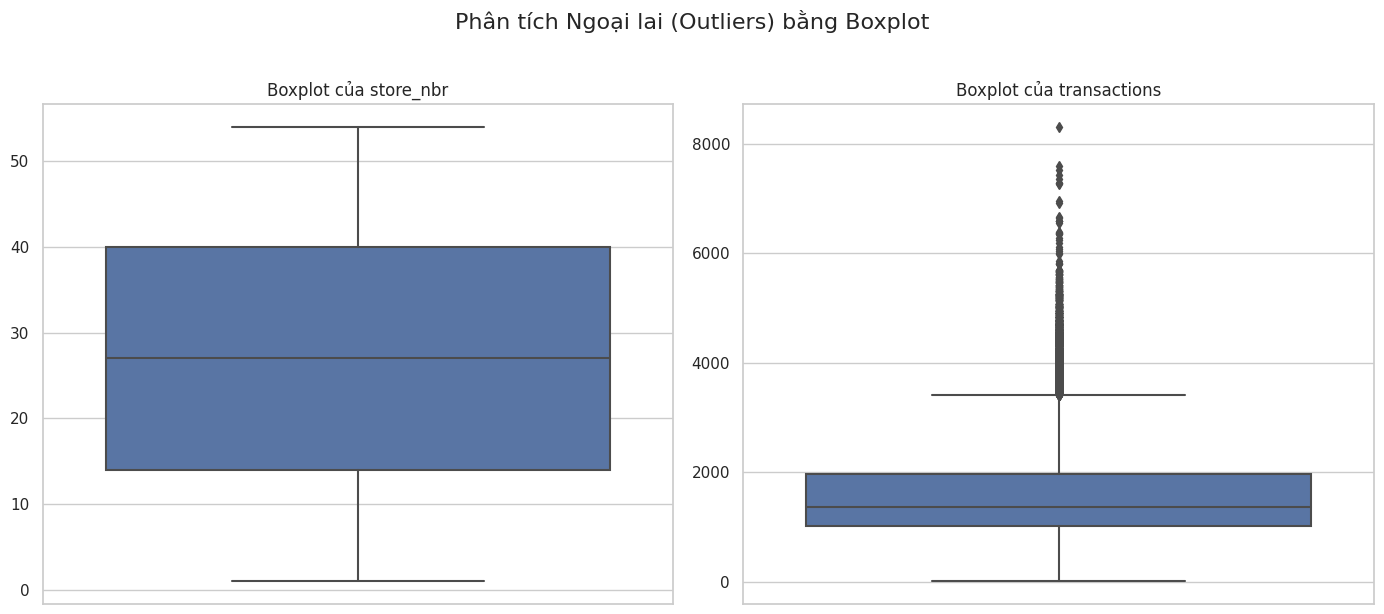

In [24]:
# Trực quan dữ liệu để kiểm tra outlier
sns.set_theme(style="whitegrid")

# Danh sách các cột kiểm tra outlier
cols_to_plot = ['store_nbr', 'transactions']

n_features = len(cols_to_plot)

# Vẽ Boxplot
fig, axes = plt.subplots(nrows=1, ncols=n_features, figsize=(7 * n_features, 6))

# Đặt tiêu đề chung cho tất cả biểu đồ
fig.suptitle('Phân tích Ngoại lai (Outliers) bằng Boxplot', fontsize=16, y=1.02)

if n_features == 1:
    axes = [axes]

for i, col in enumerate(cols_to_plot):
    print(f"Đang tạo boxplot cho cột: {col}...")
    
    sns.boxplot(data=transactions_pruned, y=col, ax=axes[i])
    
    axes[i].set_title(f"Boxplot của {col}", fontsize=12)
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

In [25]:
# Xác định ngưỡng Outlier cho 'transactions' (dựa trên phương pháp IQR)
Q1 = transactions_pruned['transactions'].quantile(0.25)
Q3 = transactions_pruned['transactions'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

print(f"Ngưỡng Q1: {Q1}")
print(f"Ngưỡng Q3: {Q3}")
print(f"Ngưỡng Outlier (Giới hạn trên = Q3 + 1.5*IQR): {upper_bound:.2f}")

# Lọc tất cả các ngày có transactions được coi là ngoại lai
outlier_trans_df = transactions_pruned[
    transactions_pruned['transactions'] > upper_bound
].copy()

print(f"\nTìm thấy {len(outlier_trans_df)} ngày có transactions là ngoại lai (cao hơn {upper_bound:.2f}).")

Ngưỡng Q1: 1011.0
Ngưỡng Q3: 1971.0
Ngưỡng Outlier (Giới hạn trên = Q3 + 1.5*IQR): 3411.00

Tìm thấy 2092 ngày có transactions là ngoại lai (cao hơn 3411.00).


In [26]:
outlier_trans_df

,date,store_nbr,transactions
26,2016-01-02,44,4539
27,2016-01-02,45,4840
28,2016-01-02,46,5256
29,2016-01-02,47,4967
30,2016-01-02,48,4574
...,...,...,...
31032,2017-08-14,45,3743
31034,2017-08-14,47,3606
31085,2017-08-15,44,3815
31086,2017-08-15,45,3685


Ghi chú: Các giá trị transactions tăng đột biến vào các ngày như 2016-01-02, 2016-12-23, 2017-08-14 và 2017-08-15 được xác định là outlier về mặt thống kê, tuy nhiên đều là outlier hợp lý. Cụ thể, những thời điểm này trùng với mùa mua sắm lễ Tết Dương lịch, cao điểm Giáng sinh, và lễ Đức Mẹ Lên Trời – các dịp người dân Ecuador thường mua sắm, du lịch và tổ chức lễ hội nhiều hơn bình thường. Vì vậy, các outlier này phản ánh biến động thực tế trong hành vi tiêu dùng, không phải dữ liệu bất thường hay lỗi, nên được giữ lại trong phân tích.

In [27]:
# Giải phóng dung lượng
del outlier_trans_df
gc.collect()

10581

In [28]:
# Thêm các cột thời gian

transactions_pruned['year'] = transactions_pruned['date'].dt.year
transactions_pruned['month'] = transactions_pruned['date'].dt.month
transactions_pruned['day'] = transactions_pruned['date'].dt.day
transactions_pruned['dayofweek'] = transactions_pruned['date'].dt.dayofweek

transactions_pruned["weekofyear"] = transactions_pruned["date"].dt.isocalendar().week.astype(int)
transactions_pruned["is_weekend"] = transactions_pruned["dayofweek"].isin([5, 6]).astype(int)
transactions_pruned["quarter"] = transactions_pruned["date"].dt.quarter

# Đánh dấu đầu tháng/cuối tháng
transactions_pruned["is_month_start"] = transactions_pruned["date"].dt.is_month_start.astype(int)
transactions_pruned["is_month_end"] = transactions_pruned["date"].dt.is_month_end.astype(int)

transactions_pruned["season"] = transactions_pruned["month"].apply(season_from_month)

# --- Kiểm tra kết quả ---
print("\nĐã thêm cột thành công!")
print("Kiểm tra 5 dòng đầu của transactions_pruned (với cột mới):")
print(transactions_pruned.head())


Đã thêm cột thành công!
Kiểm tra 5 dòng đầu của transactions_pruned (với cột mới):
        date  store_nbr  transactions  year  month  day  dayofweek  \
0 2016-01-02          2             6  2016      1    2          5   
1 2016-01-02         16           373  2016      1    2          5   
2 2016-01-02         20          1816  2016      1    2          5   
3 2016-01-02         21          1388  2016      1    2          5   
4 2016-01-02         22           849  2016      1    2          5   

   weekofyear  is_weekend  quarter  is_month_start  is_month_end  season  
0          53           1        1               0             0       0  
1          53           1        1               0             0       0  
2          53           1        1               0             0       0  
3          53           1        1               0             0       0  
4          53           1        1               0             0       0  


In [ ]:
# Ghi file csv
transactions_pruned.to_csv("transactions_final.csv", index=False)
print("Đã xuất file thành công!")

## Tiền xử lý tập oil_pruned

In [30]:
oil_pruned.shape

(435, 2)

In [31]:
oil_pruned.head()

,date,dcoilwtico
0,2016-01-01,NaN
1,2016-01-04,36.81
2,2016-01-05,35.97
3,2016-01-06,33.97
4,2016-01-07,33.29


In [32]:
# Kiểm tra null
print("Tổng số giá trị null: ", check_null(oil_pruned))

# Kiểm tra trùng lặp
print("Tổng số giá trị trùng lặp: ", check_duplicate(oil_pruned))

# Kiểm tra giá trị âm
print("Tổng số giá trị âm: ", check_negative(oil_pruned))

# Kiểm tra giá trị có ký tự đặc biệt
print("Tổng số giá trị có ký tự đặc biệt: ", check_strange_char(oil_pruned))

Tổng số giá trị null:  {'date': 0, 'dcoilwtico': 16}
Số dòng trùng lặp: 0
Tổng số giá trị trùng lặp:  0
Tổng số giá trị âm:  {'dcoilwtico': 0}
Tổng số giá trị có ký tự đặc biệt:  {}


In [33]:
# Kiểm tra thông tin dữ liệu có dcoilwtico bị null
oil_pruned[oil_pruned['dcoilwtico'].isnull()]

,date,dcoilwtico
0,2016-01-01,NaN
11,2016-01-18,NaN
31,2016-02-15,NaN
60,2016-03-25,NaN
106,2016-05-30,NaN
131,2016-07-04,NaN
176,2016-09-05,NaN
234,2016-11-24,NaN
256,2016-12-26,NaN
261,2017-01-02,NaN


In [34]:
# Xử lý null
print(f"Số lượng giá trị null trong 'dcoilwtico' ban đầu: {oil_pruned['dcoilwtico'].isnull().sum()}")

# Sử dụng 'ffill' (forward fill) để fill giá trị null bằng giá trị của ngày trước đó
oil_pruned['dcoilwtico'] = oil_pruned['dcoilwtico'].fillna(method='ffill')

# Xử lý trường hợp đặc biệt nếu phía trước dữ liệu null không có dữ liệu nào trước đó -> Dùng 'bfill' (backward fill)
oil_pruned['dcoilwtico'] = oil_pruned['dcoilwtico'].fillna(method='bfill')

# Kiểm tra lại
final_null_count = oil_pruned['dcoilwtico'].isnull().sum()
print(f"Số lượng giá trị null trong 'dcoilwtico' sau khi fill: {final_null_count}")

if final_null_count == 0:
    print("Đã fill thành công!")
else:
    print("Vẫn còn giá trị null, vui lòng kiểm tra lại.")

Số lượng giá trị null trong 'dcoilwtico' ban đầu: 16
Số lượng giá trị null trong 'dcoilwtico' sau khi fill: 0
Đã fill thành công!


/tmp/ipykernel_47/2972458142.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil_pruned['dcoilwtico'] = oil_pruned['dcoilwtico'].fillna(method='ffill')
/tmp/ipykernel_47/2972458142.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil_pruned['dcoilwtico'] = oil_pruned['dcoilwtico'].fillna(method='bfill')


In [35]:
# Thêm các cột thời gian

oil_pruned['year'] = oil_pruned['date'].dt.year
oil_pruned['month'] = oil_pruned['date'].dt.month
oil_pruned['day'] = oil_pruned['date'].dt.day
oil_pruned['dayofweek'] = oil_pruned['date'].dt.dayofweek

oil_pruned["weekofyear"] = oil_pruned["date"].dt.isocalendar().week.astype(int)
oil_pruned["is_weekend"] = oil_pruned["dayofweek"].isin([5, 6]).astype(int)
oil_pruned["quarter"] = oil_pruned["date"].dt.quarter

# Đánh dấu đầu tháng/cuối tháng
oil_pruned["is_month_start"] = oil_pruned["date"].dt.is_month_start.astype(int)
oil_pruned["is_month_end"] = oil_pruned["date"].dt.is_month_end.astype(int)

oil_pruned["season"] = oil_pruned["month"].apply(season_from_month)

# --- Kiểm tra kết quả ---
print("\nĐã thêm cột thành công!")
print("Kiểm tra 5 dòng đầu của oil_pruned (với cột mới):")
print(oil_pruned.head())


Đã thêm cột thành công!
Kiểm tra 5 dòng đầu của oil_pruned (với cột mới):
        date  dcoilwtico  year  month  day  dayofweek  weekofyear  is_weekend  \
0 2016-01-01       36.81  2016      1    1          4          53           0   
1 2016-01-04       36.81  2016      1    4          0           1           0   
2 2016-01-05       35.97  2016      1    5          1           1           0   
3 2016-01-06       33.97  2016      1    6          2           1           0   
4 2016-01-07       33.29  2016      1    7          3           1           0   

   quarter  is_month_start  is_month_end  season  
0        1               1             0       0  
1        1               0             0       0  
2        1               0             0       0  
3        1               0             0       0  
4        1               0             0       0  


Đang tạo boxplot cho cột: dcoilwtico...


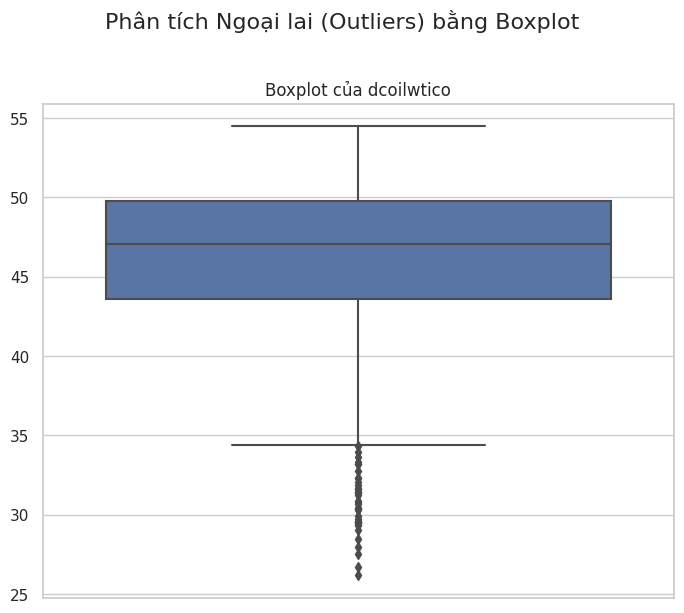

In [36]:
# Trực quan dữ liệu để kiểm tra outlier
sns.set_theme(style="whitegrid")

# Danh sách các cột kiểm tra outlier
cols_to_plot = ['dcoilwtico']

n_features = len(cols_to_plot)

# Vẽ Boxplot
fig, axes = plt.subplots(nrows=1, ncols=n_features, figsize=(7 * n_features, 6))

# Đặt tiêu đề chung cho tất cả biểu đồ
fig.suptitle('Phân tích Ngoại lai (Outliers) bằng Boxplot', fontsize=16, y=1.02)

if n_features == 1:
    axes = [axes]

for i, col in enumerate(cols_to_plot):
    print(f"Đang tạo boxplot cho cột: {col}...")
    
    sns.boxplot(data=oil_pruned, y=col, ax=axes[i])
    
    axes[i].set_title(f"Boxplot của {col}", fontsize=12)
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

In [37]:
# Xác định ngưỡng Outlier cho 'dcoilwtico' (dựa trên phương pháp IQR)
Q1 = oil_pruned['dcoilwtico'].quantile(0.25)
Q3 = oil_pruned['dcoilwtico'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR

print(f"Ngưỡng Q1: {Q1}")
print(f"Ngưỡng Q3: {Q3}")
print(f"Ngưỡng Outlier (Giới hạn dưới = Q1 - 1.5*IQR): {lower_bound:.2f}")

# Lọc tất cả các ngày có dcoilwtico được coi là ngoại lai
outlier_oil_df = oil_pruned[
    oil_pruned['dcoilwtico'] < lower_bound
].copy()

print(f"\nTìm thấy {len(outlier_oil_df)} ngày có dcoilwtico là ngoại lai (thấp hơn {lower_bound:.2f}).")

Ngưỡng Q1: 43.565
Ngưỡng Q3: 49.735
Ngưỡng Outlier (Giới hạn dưới = Q1 - 1.5*IQR): 34.31

Tìm thấy 40 ngày có dcoilwtico là ngoại lai (thấp hơn 34.31).


In [38]:
outlier_oil_df

,date,dcoilwtico,year,month,day,dayofweek,weekofyear,is_weekend,quarter,is_month_start,is_month_end,season
3,2016-01-06,33.97,2016,1,6,2,1,0,1,0,0,0
4,2016-01-07,33.29,2016,1,7,3,1,0,1,0,0,0
5,2016-01-08,33.20,2016,1,8,4,1,0,1,0,0,0
6,2016-01-11,31.42,2016,1,11,0,2,0,1,0,0,0
7,2016-01-12,30.42,2016,1,12,1,2,0,1,0,0,0
8,2016-01-13,30.42,2016,1,13,2,2,0,1,0,0,0
9,2016-01-14,31.22,2016,1,14,3,2,0,1,0,0,0
10,2016-01-15,29.45,2016,1,15,4,2,0,1,0,0,0
11,2016-01-18,29.45,2016,1,18,0,3,0,1,0,0,0
12,2016-01-19,28.47,2016,1,19,1,3,0,1,0,0,0


Nhận xét: Trong đầu năm 2016, giá dầu thế giới thực sự giảm rất mạnh, có lúc chạm ~26–30 USD/thùng do: Khủng hoảng cung – cầu dầu mỏ, OPEC không cắt giảm sản lượng, nhu cầu từ Trung Quốc giảm mạnh, và tồn kho dầu ở Mỹ cao kỷ lục -> Các giá trị outlier phản ánh biến động thật của giá dầu, không phải thiếu hoặc lỗi dữ liệu -> Giữ lại các outlier

In [39]:
# Giải phóng dung lượng
del outlier_oil_df
gc.collect()

5208

In [ ]:
# Ghi file csv
oil_pruned.to_csv("oil_final.csv", index=False)
print("Đã xuất file thành công!")

## Tiền xử lý tập holidays_pruned

In [41]:
holidays_pruned.shape

(139, 6)

In [42]:
holidays_pruned.head()

,date,type,locale,locale_name,description,transferred
0,2016-01-01,Holiday,National,Ecuador,Primer dia del ano,False
1,2016-02-08,Holiday,National,Ecuador,Carnaval,False
2,2016-02-09,Holiday,National,Ecuador,Carnaval,False
3,2016-03-02,Holiday,Local,Manta,Fundacion de Manta,False
4,2016-03-25,Holiday,National,Ecuador,Viernes Santo,False


In [43]:
# Kiểm tra null
print("Tổng số giá trị null: ", check_null(holidays_pruned))

# Kiểm tra trùng lặp
print("Tổng số giá trị trùng lặp: ", check_duplicate(holidays_pruned))

# Kiểm tra giá trị âm
print("Tổng số giá trị âm: ", check_negative(holidays_pruned))

# Kiểm tra giá trị có ký tự đặc biệt
print("Tổng số giá trị có ký tự đặc biệt: ", check_strange_char(holidays_pruned))

Tổng số giá trị null:  {'date': 0, 'type': 0, 'locale': 0, 'locale_name': 0, 'description': 0, 'transferred': 0}
Số dòng trùng lặp: 0
Tổng số giá trị trùng lặp:  0
Tổng số giá trị âm:  {}
Tổng số giá trị có ký tự đặc biệt:  {'type': 0, 'locale': 0, 'locale_name': 0, 'description': 32}


In [44]:
# Định nghĩa pattern ký tự đặc biệt (có thể tinh chỉnh)
pattern = r"[^a-zA-Z0-9\s.,:/\-_]"

condition = holidays_pruned["description"].str.contains(pattern, na=False)

rows_with_special = holidays_pruned[condition]

# In kết quả
print(f"Số dòng chứa ký tự đặc biệt: {len(rows_with_special)}")

print("\n--- Hiển thị các dòng chứa ký tự đặc biệt ---")

print(rows_with_special)

Số dòng chứa ký tự đặc biệt: 32

--- Hiển thị các dòng chứa ký tự đặc biệt ---
          date        type    locale locale_name          description  \
9   2016-04-17       Event  National     Ecuador   Terremoto Manabi+1   
10  2016-04-18       Event  National     Ecuador   Terremoto Manabi+2   
11  2016-04-19       Event  National     Ecuador   Terremoto Manabi+3   
12  2016-04-20       Event  National     Ecuador   Terremoto Manabi+4   
14  2016-04-21       Event  National     Ecuador   Terremoto Manabi+5   
15  2016-04-22       Event  National     Ecuador   Terremoto Manabi+6   
16  2016-04-23       Event  National     Ecuador   Terremoto Manabi+7   
17  2016-04-24       Event  National     Ecuador   Terremoto Manabi+8   
18  2016-04-25       Event  National     Ecuador   Terremoto Manabi+9   
19  2016-04-26       Event  National     Ecuador  Terremoto Manabi+10   
20  2016-04-27       Event  National     Ecuador  Terremoto Manabi+11   
21  2016-04-28       Event  National     Ecua

Giải thích: Dấu + (cộng) không phải là dữ liệu lỗi hay ký tự đặc biệt, mà là một ký hiệu ghi chú (notation) có chủ đích. Nó được sử dụng trong cột description để đánh dấu những ngày nghỉ bổ sung hoặc ngày liên quan ngay lập tức sau một sự kiện hoặc ngày lễ chính. Các ngày này thường là "ngày nghỉ bù" (bridge days) hoặc các ngày quan sát/phục hồi sau một sự kiện lớn.

In [45]:
# Chuyển cột transferred từ bool sang binary (0 và 1)
holidays_pruned['transferred'] = holidays_pruned['transferred'].astype('int8')
holidays_pruned.head()

,date,type,locale,locale_name,description,transferred
0,2016-01-01,Holiday,National,Ecuador,Primer dia del ano,0
1,2016-02-08,Holiday,National,Ecuador,Carnaval,0
2,2016-02-09,Holiday,National,Ecuador,Carnaval,0
3,2016-03-02,Holiday,Local,Manta,Fundacion de Manta,0
4,2016-03-25,Holiday,National,Ecuador,Viernes Santo,0


In [46]:
# Thêm các cột thời gian

holidays_pruned['year'] = holidays_pruned['date'].dt.year
holidays_pruned['month'] = holidays_pruned['date'].dt.month
holidays_pruned['day'] = holidays_pruned['date'].dt.day
holidays_pruned['dayofweek'] = holidays_pruned['date'].dt.dayofweek

holidays_pruned["weekofyear"] = holidays_pruned["date"].dt.isocalendar().week.astype(int)
holidays_pruned["is_weekend"] = holidays_pruned["dayofweek"].isin([5, 6]).astype(int)
holidays_pruned["quarter"] = holidays_pruned["date"].dt.quarter

# Đánh dấu đầu tháng/cuối tháng
holidays_pruned["is_month_start"] = holidays_pruned["date"].dt.is_month_start.astype(int)
holidays_pruned["is_month_end"] = holidays_pruned["date"].dt.is_month_end.astype(int)

holidays_pruned["season"] = holidays_pruned["month"].apply(season_from_month)

# --- Kiểm tra kết quả ---
print("\nĐã thêm cột thành công!")
print("Kiểm tra 5 dòng đầu của holidays_pruned (với cột mới):")
print(holidays_pruned.head())


Đã thêm cột thành công!
Kiểm tra 5 dòng đầu của holidays_pruned (với cột mới):
        date     type    locale locale_name         description  transferred  \
0 2016-01-01  Holiday  National     Ecuador  Primer dia del ano            0   
1 2016-02-08  Holiday  National     Ecuador            Carnaval            0   
2 2016-02-09  Holiday  National     Ecuador            Carnaval            0   
3 2016-03-02  Holiday     Local       Manta  Fundacion de Manta            0   
4 2016-03-25  Holiday  National     Ecuador       Viernes Santo            0   

   year  month  day  dayofweek  weekofyear  is_weekend  quarter  \
0  2016      1    1          4          53           0        1   
1  2016      2    8          0           6           0        1   
2  2016      2    9          1           6           0        1   
3  2016      3    2          2           9           0        1   
4  2016      3   25          4          12           0        1   

   is_month_start  is_month_end  sea

In [ ]:
# Ghi file csv
holidays_pruned.to_csv("holidays_final.csv", index=False)
print("Đã xuất file thành công!")

## Tiền xử lý tập items

In [48]:
items = pd.read_csv("/kaggle/working/items.csv")

In [49]:
items.shape

(4100, 4)

In [50]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [51]:
# Kiểm tra giá trị null
print("Tổng số giá trị null:\n", items.isnull().sum(), "\n")

# Kiểm tra trùng lặp
print("Số dòng trùng lặp hoàn toàn:", items.duplicated().sum())
print("Số item_nbr trùng:", items.duplicated(subset=['item_nbr']).sum(), "\n")

# Kiểm tra giá trị âm (chỉ các cột numeric)
num_cols = items.select_dtypes(include='number').columns
print("Số giá trị âm theo cột:\n", (items[num_cols] < 0).sum(), "\n")

# Kiểm tra ký tự đặc biệt (chỉ cột string)
pattern = r"[^a-zA-Z0-9\s.,:/\-_+]"
str_cols = items.select_dtypes(include='object').columns
print("Số giá trị có ký tự đặc biệt theo cột:\n",
      items[str_cols].apply(lambda s: s.astype(str).str.contains(pattern, regex=True, na=False).sum()))

Tổng số giá trị null:
 item_nbr      0
family        0
class         0
perishable    0
dtype: int64 

Số dòng trùng lặp hoàn toàn: 0
Số item_nbr trùng: 0 

Số giá trị âm theo cột:
 item_nbr      0
class         0
perishable    0
dtype: int64 

Số giá trị có ký tự đặc biệt theo cột:
 family    0
dtype: int64


## Tiền xử lý tập stores

In [52]:
stores = pd.read_csv("/kaggle/working/stores.csv")

In [53]:
stores.shape

(54, 5)

In [54]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [55]:
# Kiểm tra giá trị null
print("Tổng số giá trị null:\n", stores.isnull().sum(), "\n")

# Kiểm tra trùng lặp
print("Số dòng trùng lặp hoàn toàn:", stores.duplicated().sum())
print("Số store_nbr trùng:", stores.duplicated(subset=['store_nbr']).sum(), "\n")

# Kiểm tra giá trị âm (chỉ các cột numeric)
num_cols = stores.select_dtypes(include='number').columns
print("Số giá trị âm theo cột:\n", (stores[num_cols] < 0).sum(), "\n")

# Kiểm tra ký tự đặc biệt (chỉ cột string)
pattern = r"[^a-zA-Z0-9\s.,:/\-_+]"
str_cols = stores.select_dtypes(include='object').columns
print("Số giá trị có ký tự đặc biệt theo cột:\n",
      stores[str_cols].apply(lambda s: s.astype(str).str.contains(pattern, regex=True, na=False).sum()))

Tổng số giá trị null:
 store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64 

Số dòng trùng lặp hoàn toàn: 0
Số store_nbr trùng: 0 

Số giá trị âm theo cột:
 store_nbr    0
cluster      0
dtype: int64 

Số giá trị có ký tự đặc biệt theo cột:
 city     0
state    0
type     0
dtype: int64


# EDA thống kê cơ bản

In [56]:
# Train
print("Thống kê kiểu dữ liệu: ")
print(train_pruned.dtypes)

print("\n=====================\n")
print("Thống kê mô tả unit_sales:")
print("Min: ", train_pruned['unit_sales'].min())
print("Max: ", train_pruned['unit_sales'].max())

print("\n=====================\n")
print("Thống kê mô tả onpromotion:")
# Tính số lượng và tỷ lệ phần trăm cho mỗi giá trị unique
promotion_counts = train_pruned['onpromotion'].value_counts()
promotion_ratios = train_pruned['onpromotion'].value_counts(normalize=True) * 100

# In kết quả cho 0 (Không Khuyến mãi)
count_0 = promotion_counts.get(0, 0)
ratio_0 = promotion_ratios.get(0, 0)
print(f"0 (Không Khuyến mãi)         | {count_0:<17} | {ratio_0:.4f}%")

# In kết quả cho 1 (Có Khuyến mãi)
count_1 = promotion_counts.get(1, 0)
ratio_1 = promotion_ratios.get(1, 0)
print(f"1 (Có Khuyến mãi)            | {count_1:<17} | {ratio_1:.4f}%")

Thống kê kiểu dữ liệu: 
date              datetime64[ns]
store_nbr                  int64
item_nbr                   int64
unit_sales               float64
onpromotion                 int8
year                       int32
month                      int32
day                        int32
dayofweek                  int32
weekofyear                 int64
is_weekend                 int64
quarter                    int32
is_month_start             int64
is_month_end               int64
season                     int64
dtype: object


Thống kê mô tả unit_sales:
Min:  0.0
Max:  89440.0


Thống kê mô tả onpromotion:
0 (Không Khuyến mãi)         | 52773899          | 89.3895%
1 (Có Khuyến mãi)            | 6264233           | 10.6105%


In [57]:
# Transactions
print("Thống kê kiểu dữ liệu: ")
print(transactions_pruned.dtypes)

print("\n=====================\n")
print("Thống kê mô tả transactions:")
transactions_pruned['transactions'].describe().round()

Thống kê kiểu dữ liệu: 
date              datetime64[ns]
store_nbr                  int64
transactions               int64
year                       int32
month                      int32
day                        int32
dayofweek                  int32
weekofyear                 int64
is_weekend                 int64
quarter                    int32
is_month_start             int64
is_month_end               int64
season                     int64
dtype: object


Thống kê mô tả transactions:


count    31096.0
mean      1642.0
std        939.0
min          5.0
25%       1011.0
50%       1355.0
75%       1971.0
max       8307.0
Name: transactions, dtype: float64

In [58]:
# Oil
print("Thống kê kiểu dữ liệu: ")
print(oil_pruned.dtypes)

print("\n=====================\n")
print("Thống kê mô tả oil:")
oil_pruned['dcoilwtico'].describe().round(2)

Thống kê kiểu dữ liệu: 
date              datetime64[ns]
dcoilwtico               float64
year                       int32
month                      int32
day                        int32
dayofweek                  int32
weekofyear                 int64
is_weekend                 int64
quarter                    int32
is_month_start             int64
is_month_end               int64
season                     int64
dtype: object


Thống kê mô tả oil:


count    435.00
mean      45.66
std        6.34
min       26.19
25%       43.56
50%       47.02
75%       49.74
max       54.48
Name: dcoilwtico, dtype: float64

In [59]:
# Holidays
print("Thống kê kiểu dữ liệu: ")
print(holidays_pruned.dtypes)

print("\n=====================\n")
print("Thống kê mô tả transferred:")
# Tính số lượng và tỷ lệ phần trăm cho mỗi giá trị unique
transferred_counts = holidays_pruned['transferred'].value_counts()
transferred_ratios = holidays_pruned['transferred'].value_counts(normalize=True) * 100

# In kết quả cho 0 (Ngày tổ chức lễ gốc)
count_0 = transferred_counts.get(0, 0)
ratio_0 = transferred_ratios.get(0, 0)
print(f"0 (Ngày tổ chức lễ gốc)                   | {count_0:<17} | {ratio_0:.4f}%")

# In kết quả cho 1 (Ngày tổ chức lễ bị dời sang ngày khác)
count_1 = transferred_counts.get(1, 0)
ratio_1 = transferred_ratios.get(1, 0)
print(f"1 (Ngày tổ chức lễ bị dời sang ngày khác) | {count_1:<17} | {ratio_1:.4f}%")

Thống kê kiểu dữ liệu: 
date              datetime64[ns]
type                      object
locale                    object
locale_name               object
description               object
transferred                 int8
year                       int32
month                      int32
day                        int32
dayofweek                  int32
weekofyear                 int64
is_weekend                 int64
quarter                    int32
is_month_start             int64
is_month_end               int64
season                     int64
dtype: object


Thống kê mô tả transferred:
0 (Ngày tổ chức lễ gốc)                   | 130               | 93.5252%
1 (Ngày tổ chức lễ bị dời sang ngày khác) | 9                 | 6.4748%


In [60]:
# Items
print("Thống kê kiểu dữ liệu: ")
print(items.dtypes)

print("\n=====================\n")
print("Thống kê mô tả perishable:")
# Tính số lượng và tỷ lệ phần trăm cho mỗi giá trị unique
perishable_counts = items['perishable'].value_counts()
perishable_ratios = items['perishable'].value_counts(normalize=True) * 100

# In kết quả cho 0 (Sản phẩm bền)
count_0 = perishable_counts.get(0, 0)
ratio_0 = perishable_ratios.get(0, 0)
print(f"0 (Sản phẩm bền)         | {count_0:<17} | {ratio_0:.4f}%")

# In kết quả cho 1 (Sản phẩm dễ hư hỏng)
count_1 = perishable_counts.get(1, 0)
ratio_1 = perishable_ratios.get(1, 0)
print(f"1 (Sản phẩm dễ hư hỏng)  | {count_1:<17} | {ratio_1:.4f}%")

Thống kê kiểu dữ liệu: 
item_nbr       int64
family        object
class          int64
perishable     int64
dtype: object


Thống kê mô tả perishable:
0 (Sản phẩm bền)         | 3114              | 75.9512%
1 (Sản phẩm dễ hư hỏng)  | 986               | 24.0488%


In [61]:
# Stores
print("Thống kê kiểu dữ liệu: ")
print(stores.dtypes)

print("\n=====================\n")
print("Thống kê giá trị unique của city/state/type/cluster:")
# Danh sách các cột cần thống kê
cols_to_check = ['city', 'state', 'type', 'cluster']

for col in cols_to_check:
    print(f"\nCột: {col} ({len(stores[col].unique())} giá trị duy nhất)")
    # In ra tất cả các giá trị unique
    print(stores[col].unique())

Thống kê kiểu dữ liệu: 
store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object


Thống kê giá trị unique của city/state/type/cluster:

Cột: city (22 giá trị duy nhất)
['Quito' 'Santo Domingo' 'Cayambe' 'Latacunga' 'Riobamba' 'Ibarra'
 'Guaranda' 'Puyo' 'Ambato' 'Guayaquil' 'Salinas' 'Daule' 'Babahoyo'
 'Quevedo' 'Playas' 'Libertad' 'Cuenca' 'Loja' 'Machala' 'Esmeraldas'
 'Manta' 'El Carmen']

Cột: state (16 giá trị duy nhất)
['Pichincha' 'Santo Domingo de los Tsachilas' 'Cotopaxi' 'Chimborazo'
 'Imbabura' 'Bolivar' 'Pastaza' 'Tungurahua' 'Guayas' 'Santa Elena'
 'Los Rios' 'Azuay' 'Loja' 'El Oro' 'Esmeraldas' 'Manabi']

Cột: type (5 giá trị duy nhất)
['D' 'B' 'C' 'E' 'A']

Cột: cluster (17 giá trị duy nhất)
[13  8  9  4  6 15  7  3 12 16  1 10  2  5 11 14 17]


# Xây dựng mô hình phân tích dự báo

## Chuẩn bị bảng train để feature engineering

In [62]:
train_pruned.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,dayofweek,weekofyear,is_weekend,quarter,is_month_start,is_month_end,season
0,2016-01-01,25,105574,12.0,0,2016,1,1,4,53,0,1,1,0,0
1,2016-01-01,25,105575,9.0,0,2016,1,1,4,53,0,1,1,0,0
2,2016-01-01,25,105857,3.0,0,2016,1,1,4,53,0,1,1,0,0
3,2016-01-01,25,108634,3.0,0,2016,1,1,4,53,0,1,1,0,0
4,2016-01-01,25,108701,2.0,1,2016,1,1,4,53,0,1,1,0,0


In [63]:
train_pruned.drop(columns=['year','month','quarter', 'season'], inplace=True)

In [64]:
train_pruned.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,day,dayofweek,weekofyear,is_weekend,is_month_start,is_month_end
0,2016-01-01,25,105574,12.0,0,1,4,53,0,1,0
1,2016-01-01,25,105575,9.0,0,1,4,53,0,1,0
2,2016-01-01,25,105857,3.0,0,1,4,53,0,1,0
3,2016-01-01,25,108634,3.0,0,1,4,53,0,1,0
4,2016-01-01,25,108701,2.0,1,1,4,53,0,1,0


In [65]:
# sales lấy dữ liệu từ 2017-01-01 đến hết 2017-07-01 để huấn luyện mô hình
sales = train_pruned
sales = sales[(sales["date"] >= "2017-01-01") & (sales["date"] < "2017-07-01")]

# Target transformation
sales["log_sales"] = np.log1p(sales["unit_sales"]) # Biến target

# Sort bắt buộc cho các hàm shift/rolling
sales = sales.sort_values(["store_nbr", "item_nbr", "date"])

print("Sales base:", sales.shape)

/tmp/ipykernel_47/2422191139.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales["log_sales"] = np.log1p(sales["unit_sales"]) # Biến target


Sales base: (18954132, 12)


In [66]:
import gc
del train_pruned
gc.collect()

13

### Tạo features lag/rolling

In [ ]:
# ===== LAG & ROLLING (TỐI ƯU HÓA) =====
# Tạo Group object 1 lần để tái sử dụng -> Tốc độ nhanh hơn gấp đôi
grouper_sales = sales.groupby(["store_nbr", "item_nbr"])["log_sales"]

# ===== LAG để bắt chu kỳ =====
for lag in [3,7]:
    sales[f"lag_{lag}"] = grouper_sales.shift(lag).astype("float32")

# ===== ROLLING (sales) =====
sales["rolling_mean_3_sales"] = (
    grouper_sales.transform(lambda x: x.shift(1).rolling(3).mean())
    .astype("float32")
)
sales["rolling_mean_7_sales"] = (
    grouper_sales.transform(lambda x: x.shift(1).rolling(7).mean())
    .astype("float32")
)

# Fill NA do lag
lag_cols = [c for c in sales.columns if "lag_" in c or "rolling_" in c or "ewm_" in c]
sales[lag_cols] = sales[lag_cols].fillna(0)

print("After lag/rolling:", sales.shape)

After lag/rolling: (18954132, 16)


### Tạo features Family baseline

In [68]:
item_stats = (
    sales[['item_nbr', 'unit_sales']]
    .groupby('item_nbr')['unit_sales']
    .agg(['sum', 'count'])
    .reset_index()
)
item_stats = item_stats.merge(items[['item_nbr', 'family']], on='item_nbr', how='left')
family_agg = item_stats.groupby('family')[['sum', 'count']].sum().reset_index()
family_agg['family_avg_sales'] = (family_agg['sum'] / family_agg['count']).astype("float32")
family_avg = family_agg[['family', 'family_avg_sales']].copy()

# Dọn dẹp biến tạm
del item_stats, family_agg
gc.collect()

0

### Tạo features Store baseline

In [69]:
store_avg = (
    sales[['store_nbr', 'unit_sales']]
    .groupby("store_nbr")
    .mean()
    .reset_index()
    .rename(columns={"unit_sales": "store_avg_sales"})
)
store_avg["store_avg_sales"] = store_avg["store_avg_sales"].astype("float32")

### Tạo feature Transactions baseline

In [70]:
transactions_pruned = transactions_pruned.sort_values(['store_nbr', 'date'])
trans_grouper = transactions_pruned.groupby('store_nbr')['transactions']

print("Đang tạo Transaction Features...")
# Dynamic
transactions_pruned['trans_lag_7'] = trans_grouper.shift(7)
transactions_pruned['trans_roll_7'] = trans_grouper.transform(lambda x: x.shift(1).rolling(7).mean())

# Static Baseline
store_trans_avg = transactions_pruned.groupby('store_nbr')['transactions'].mean()
transactions_pruned['store_avg_trans'] = transactions_pruned['store_nbr'].map(store_trans_avg)

# Prepare Merge
trans_cols = ['date', 'store_nbr', 'trans_lag_7', 'trans_roll_7', 'store_avg_trans']
trans_features = transactions_pruned[trans_cols].copy()

# Fill NA & Cast types
cols_to_fix = ['trans_lag_7', 'trans_roll_7', 'store_avg_trans']
trans_features[cols_to_fix] = trans_features[cols_to_fix].fillna(0).astype('float32')

print("Hoàn tất tạo feature cho bảng transactions!")

# Dọn dẹp biến tạm
del store_trans_avg, trans_grouper
gc.collect()

Đang tạo Transaction Features...
Hoàn tất tạo feature cho bảng transactions!


18

In [71]:
trans_features.head()

,date,store_nbr,trans_lag_7,trans_roll_7,store_avg_trans
36,2016-01-04,1,0.0,0.0,1503.833374
50,2016-01-05,1,0.0,0.0,1503.833374
103,2016-01-06,1,0.0,0.0,1503.833374
156,2016-01-07,1,0.0,0.0,1503.833374
209,2016-01-08,1,0.0,0.0,1503.833374


## Merge bảng sale, stores, items, transactions, family_avg, store_avg

In [72]:
df = sales.merge(items[["item_nbr", "family", "perishable"]], on="item_nbr", how="left")

# Dọn dẹp biến sales để nhẹ RAM
del sales
gc.collect()

df = df.merge(stores[["store_nbr", "state", "type"]], on="store_nbr", how="left")
df = df.merge(trans_features, on=["date", "store_nbr"], how="left")
df = df.merge(family_avg, on="family", how="left")
df = df.merge(store_avg, on="store_nbr", how="left")

print("After merge:", df.shape)

After merge: (18954132, 25)


In [73]:
check_memory_usage()

Variable Name             | Size (MB)  | Type
--------------------------------------------------
df                        |    5686.96 | DataFrame
transactions_pruned       |       3.44 | DataFrame
trans_features            |       1.07 | DataFrame
items                     |       0.35 | DataFrame
holidays_pruned           |       0.05 | DataFrame
oil_pruned                |       0.03 | DataFrame
stores                    |       0.01 | DataFrame
rows_with_special         |       0.01 | DataFrame
family_avg                |       0.00 | DataFrame
store_avg                 |       0.00 | DataFrame
condition                 |       0.00 | Series
str_cols                  |       0.00 | Index
check_output              |       0.00 | function
prune_data                |       0.00 | function
check_null                |       0.00 | function
check_duplicate           |       0.00 | function
check_negative            |       0.00 | function
check_strange_char        |       0.00 | functio

In [74]:
# Giải  phóng dung lượng
del trans_features, family_avg, store_avg, transactions_pruned, items, stores, oil_pruned, holidays_pruned, rows_with_special 
gc.collect()

33

## Tạo interaction features

In [75]:
# PROMO INTERACTIONS (Đòn bẩy)
# Promo Momentum: Hiệu quả cộng hưởng
# Chiến lược: Thay vì chỉ biết "có khuyến mãi", feature này cho biết "khuyến mãi trên nền sức mua bao nhiêu".
df["promo_momentum"] = (df["onpromotion"].values * df["rolling_mean_7_sales"].values).astype(np.float32)
df["promo_lag7"] = (df["onpromotion"].values * df["lag_7"].values).astype(np.float32)

print("Tạo interaction features cho promo thành công!")

Tạo interaction features cho promo thành công!


## Encoding features

In [76]:
# Khai báo biến cố định
TARGET = "log_sales"
CUTOFF_DATE = "2017-06-01" 

CORE_FEATURES = [
    "onpromotion", "trans_lag_7", "trans_roll_7",
    "store_avg_trans", "store_avg_sales", "family_avg_sales",
    "lag_3", "lag_7", "rolling_mean_3_sales", "rolling_mean_7_sales",
    "promo_momentum", "promo_lag7"
]

In [77]:
# Encode Category
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
if "date" in cat_cols: cat_cols.remove("date") # Không encode cột date

for col in cat_cols:
    df[col] = df[col].astype("category").cat.codes.astype("int16")

In [78]:
# Scale MinMax dữ liệu về phạm vi [0,1]
EXCLUDE_COLS = ["unit_sales", TARGET, "date"]
ALL_FEATURES = [c for c in df.columns if c not in EXCLUDE_COLS]

for col in ALL_FEATURES:
    if df[col].dtype == 'object': continue 
    _min, _max = df[col].min(), df[col].max()
    _range = _max - _min
    if _range != 0:
        df[col] = ((df[col] - _min) / _range).astype('float32')
    else:
        df[col] = 0.0

print("Scale hoàn tất!")

Scale hoàn tất!


## Chia tập Train/Test theo ngày được chọn để tách

In [79]:
df['date'] = pd.to_datetime(df['date'])
# Đảm bảo sort theo date
df = df.sort_values('date').reset_index(drop=True)

train_df = df[df['date'] < CUTOFF_DATE].copy()
test_df  = df[df['date'] >= CUTOFF_DATE].copy()

print(f"Train size: {len(train_df)} | Test size: {len(test_df)}")

Train size: 15789098 | Test size: 3165034


## Chọn top features quan trọng (chỉ dùng train) để đưa vào mô hình

In [80]:
# ===== Chọn top-20 feature importance =====
from xgboost import XGBRegressor

# CHỌN FEATURE BẰNG DỮ LIỆU GẦN NHẤT
# Lấy mẫu từ cuối danh sách (dữ liệu mới nhất) thay vì random
SAMPLE_SIZE = 500_000
if len(train_df) > SAMPLE_SIZE:
    sample_df = train_df.tail(SAMPLE_SIZE) # Lấy dữ liệu train mới nhất (tháng 4, 5)
else:
    sample_df = train_df

X_sample = sample_df[ALL_FEATURES]
y_sample = sample_df[TARGET]

# Huấn luyện nháp
xgb_select = XGBRegressor(
    n_estimators=150, learning_rate=0.1, max_depth=6, subsample=0.8,
    colsample_bytree=0.8, tree_method="hist", n_jobs=-1, random_state=42
)
xgb_select.fit(X_sample, y_sample)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

-> Selected 11 features.
Features: ['rolling_mean_7_sales', 'dayofweek', 'weekofyear', 'lag_7', 'day', 'onpromotion', 'rolling_mean_3_sales', 'trans_lag_7', 'is_weekend', 'trans_roll_7', 'family_avg_sales']


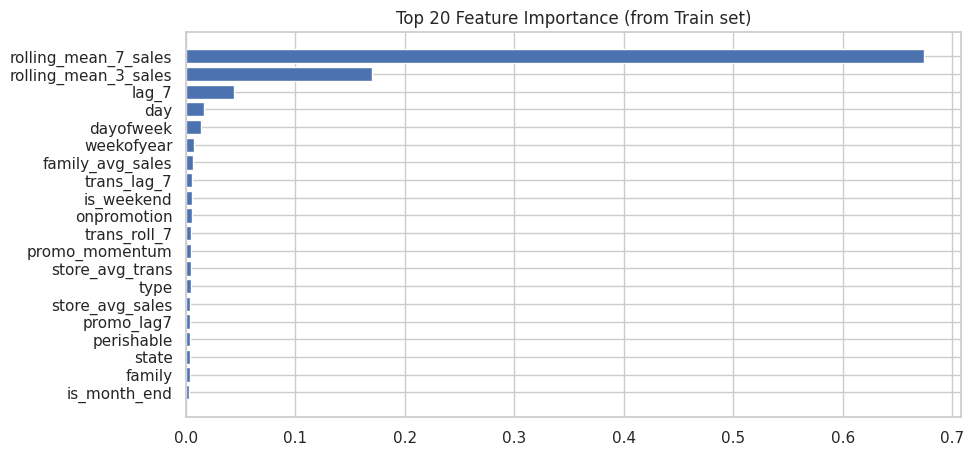


Top 20 Feature quan trọng nhất:
                 Feature  Importance
0   rolling_mean_7_sales    0.674249
1   rolling_mean_3_sales    0.170397
2                  lag_7    0.043931
3                    day    0.016965
4              dayofweek    0.013620
5             weekofyear    0.007633
6       family_avg_sales    0.006498
7            trans_lag_7    0.006026
8             is_weekend    0.005835
9            onpromotion    0.005728
10          trans_roll_7    0.005065
11        promo_momentum    0.004780
12       store_avg_trans    0.004550
13                  type    0.004410
14       store_avg_sales    0.004193
15            promo_lag7    0.003942
16            perishable    0.003678
17                 state    0.003463
18                family    0.003407
19          is_month_end    0.003264


In [81]:
# Tính toán Importance
importance_df = (
    pd.DataFrame({
        "Feature": ALL_FEATURES,
        "Importance": xgb_select.feature_importances_
    })
    .sort_values("Importance", ascending=False)
    .reset_index(drop=True)
)

# Lọc lấy Feature tiềm năng (không trùng Core)
candidates = importance_df[~importance_df["Feature"].isin(CORE_FEATURES)]
top_candidate_features = candidates["Feature"].head(7).tolist()

# Loại bỏ Feature quá yếu
THRESHOLD = 0.005
weak_features = importance_df[importance_df["Importance"] < THRESHOLD]["Feature"].tolist()

# Tổng hợp FINAL_FEATURES
temp_features = CORE_FEATURES + top_candidate_features
FINAL_FEATURES = [f for f in temp_features if f not in weak_features]
# Đảm bảo không trùng lặp
FINAL_FEATURES = list(set(FINAL_FEATURES))

print(f"-> Selected {len(FINAL_FEATURES)} features.")
print("Features:", FINAL_FEATURES)

# Vẽ biểu đồ trực quan top 20 features
plt.figure(figsize=(10, 5))
plt.barh(importance_df["Feature"].head(20)[::-1], importance_df["Importance"].head(20)[::-1])
plt.title("Top 20 Feature Importance (from Train set)")
plt.show()

# In bảng importance
print("\nTop 20 Feature quan trọng nhất:")
print(importance_df.head(20))

### Tạo X,y để đưa vào huấn luyện

In [82]:
X_train = train_df[FINAL_FEATURES]
y_train = train_df[TARGET]

X_test = test_df[FINAL_FEATURES]
y_test = test_df[TARGET]

# Fill NaN lần cuối
X_train = X_train.fillna(0)
X_test  = X_test.fillna(0)

# Downcast để giảm RAM trước khi train thật
for col in X_train.columns:
    if X_train[col].dtype == 'float64':
        X_train[col] = pd.to_numeric(X_train[col], downcast="float")
        X_test[col]  = pd.to_numeric(X_test[col], downcast="float")

print("-" * 30)
print(f"SẴN SÀNG TRAIN MODEL CHÍNH!")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape : {X_test.shape}")

------------------------------
SẴN SÀNG TRAIN MODEL CHÍNH!
X_train shape: (15789098, 11)
X_test shape : (3165034, 11)


## Các model Machine Learning


In [83]:
# Kiểm tra RAM
check_memory_usage()

Variable Name             | Size (MB)  | Type
--------------------------------------------------
df                        |    2169.13 | DataFrame
train_df                  |    1927.38 | DataFrame
X_train                   |     783.00 | DataFrame
test_df                   |     386.36 | DataFrame
y_train                   |     240.92 | Series
X_test                    |     156.96 | DataFrame
sample_df                 |      61.04 | DataFrame
X_sample                  |      49.59 | DataFrame
y_test                    |      48.29 | Series
y_sample                  |       7.63 | Series
importance_df             |       0.00 | DataFrame
XGBRegressor              |       0.00 | type
candidates                |       0.00 | DataFrame
condition                 |       0.00 | Series
ALL_FEATURES              |       0.00 | list
temp_features             |       0.00 | list
str_cols                  |       0.00 | Index
weak_features             |       0.00 | list
check_output         

In [84]:
# Giải  phóng dung lượng chiếm RAM không sử dụng nữa
del df, train_df, test_df, sample_df, X_sample, y_sample
gc.collect()

5075

### Train và so sánh 2 mô hình Machine Learning

In [85]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

# ===== Hàm tiện ích đánh giá =====
def evaluate_model(name, y_true, y_pred, start_time):
    """
    Đánh giá mô hình và trả về (rmse, mae, r2)
    """
    elapsed = (time.time() - start_time) / 60  # phút
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{name}")
    print(f"Thời gian train + predict: {elapsed:.2f} phút")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R-squared: {r2:.4f}")

    return rmse, mae, r2

# ===== Linear Regression =====
print("\n=== Bắt đầu huấn luyện Linear Regression ===")
start = time.time()
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)

pred_lr = lr.predict(X_test)
pred_lr = np.maximum(pred_lr, 0)

rmse_lr, mae_lr, r2_lr = evaluate_model("Linear Regression", y_test, pred_lr, start)

# ===== XGBoost Regressor =====
print("\n=== Bắt đầu huấn luyện XGBoost ===")
start = time.time()
xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.5,
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, # Dừng nếu 50 vòng không cải thiện trên test
        verbose=100               # In kết quả mỗi 100 vòng
)

pred_xgb = xgb.predict(X_test)
rmse_xgb, mae_xgb, r2_xgb = evaluate_model("XGBoost Regressor", y_test, pred_xgb, start)

results_df = pd.DataFrame([
    {"Model": "Linear Regression", "RMSE": rmse_lr, "MAE": mae_lr, "R2": r2_lr},
    {"Model": "XGBoost Regressor", "RMSE": rmse_xgb, "MAE": mae_xgb, "R2": r2_xgb}
]).sort_values("RMSE")

print("\nSo sánh kết quả:")
print(results_df)


=== Bắt đầu huấn luyện Linear Regression ===

Linear Regression
Thời gian train + predict: 0.10 phút
RMSE: 0.5478 | MAE: 0.4304 | R-squared: 0.6057

=== Bắt đầu huấn luyện XGBoost ===


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.85221	validation_1-rmse:0.85073
[100]	validation_0-rmse:0.51974	validation_1-rmse:0.51479
[200]	validation_0-rmse:0.51585	validation_1-rmse:0.51377
[265]	validation_0-rmse:0.51450	validation_1-rmse:0.51377

XGBoost Regressor
Thời gian train + predict: 9.39 phút
RMSE: 0.5137 | MAE: 0.4005 | R-squared: 0.6532

So sánh kết quả:
               Model      RMSE       MAE        R2
1  XGBoost Regressor  0.513722  0.400484  0.653205
0  Linear Regression  0.547779  0.430448  0.605700


## Các model Deep Learning

### Chuẩn bị dữ liệu & DataLoader

In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import copy
from tqdm import tqdm

In [87]:
# ===== Chuyển dữ liệu sang tensor =====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_np = y_train.to_numpy().astype(np.float32)
y_test_np = y_test.to_numpy().astype(np.float32)

# ===== Định nghĩa Dataset tuỳ chỉnh =====
class SalesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ===== Định nghĩa EarlyStopping dừng huấn luyện khi không học thêm được gì nữa =====
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='best_model.pt'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0 # Reset counter
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def restore_best_model(self, model):
        if self.best_model_wts:
            model.load_state_dict(self.best_model_wts)
            print("-> Đã khôi phục model tốt nhất!")
        return model

train_ds = SalesDataset(X_train_scaled, y_train_np)
test_ds  = SalesDataset(X_test_scaled, y_test_np)

# ===== Tạo DataLoader =====
BATCH_SIZE = 1024 # Tăng batch size lên để chạy nhanh hơn
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"DataLoader sẵn sàng: {len(train_loader)} batch train | {len(test_loader)} batch test")

DataLoader sẵn sàng: 15420 batch train | 3091 batch test


### Huấn luyện MLP (Fully Connected Network)

In [88]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ===== Định nghĩa mô hình MLP =====
class MLPModel(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.3):
        super().__init__()
        # Kiến trúc hình tháp ngược (Pyramid) + Batch Normalization
        self.net = nn.Sequential(
            # Layer 1
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512), # Giúp ổn định training
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # Layer 2
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # Layer 3
            nn.Linear(256, 64),
            nn.ReLU(),
            
            # Output
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.net(x)

mlp = MLPModel(input_dim=X_train_scaled.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=1e-3, weight_decay=1e-5) # Thêm weight_decay để giảm overfit
early_stopper = EarlyStopping(patience=10, path='best_checkpoint.pt') # Patience = 10 epoch

# ===== Train loop =====
epochs = 30
train_losses, val_losses = [], []
print("\nBắt đầu huấn luyện MLP...")

for epoch in range(epochs):
    mlp.train()
    running_loss = 0.0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        
        optimizer.zero_grad()
        pred = mlp(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Validation Phase (QUAN TRỌNG ĐỂ EARLY STOPPING) ---
    mlp.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = mlp(xb)
            loss = criterion(pred, yb)
            running_val_loss += loss.item()
            
    avg_val_loss = running_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}")
    
    # --- Check Early Stopping ---
    early_stopper(avg_val_loss, mlp)
    if early_stopper.early_stop:
        print(f"Early Stopping tại epoch {epoch+1}!")
        break

# Khôi phục model tốt nhất trước khi đánh giá
mlp = early_stopper.restore_best_model(mlp)

Device: cuda

Bắt đầu huấn luyện MLP...


Epoch 1: Train Loss: 0.28399 | Val Loss: 0.27166


Epoch 2: Train Loss: 0.27767 | Val Loss: 0.26464


Epoch 3: Train Loss: 0.27636 | Val Loss: 0.26554


Epoch 4: Train Loss: 0.27568 | Val Loss: 0.26873


Epoch 5: Train Loss: 0.27538 | Val Loss: 0.27178


Epoch 6: Train Loss: 0.27512 | Val Loss: 0.27424


Epoch 7: Train Loss: 0.27508 | Val Loss: 0.26985


Epoch 8: Train Loss: 0.27502 | Val Loss: 0.26913


Epoch 9: Train Loss: 0.27496 | Val Loss: 0.27469


Epoch 10: Train Loss: 0.27491 | Val Loss: 0.27727


Epoch 11: Train Loss: 0.27484 | Val Loss: 0.27635


Epoch 12: Train Loss: 0.27484 | Val Loss: 0.27349
Early Stopping tại epoch 12!
-> Đã khôi phục model tốt nhất!


### Đánh giá MLP

In [89]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mlp.eval()
preds, trues = [], []

print("\nĐang dự báo trên tập Test...")
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred = mlp(xb)
        
        # Đưa về CPU numpy
        preds.append(pred.cpu().numpy())
        trues.append(yb.numpy())

preds = np.concatenate(preds).flatten()
trues = np.concatenate(trues).flatten()

# Tính metrics chặn dưới 0
preds = np.maximum(preds, 0)

rmse_mlp = np.sqrt(mean_squared_error(trues, preds))
mae_mlp = mean_absolute_error(trues, preds)
r2_mlp = r2_score(trues, preds)

print("\nMLP Evaluation:")
print(f"RMSE: {rmse_mlp:.4f} | MAE: {mae_mlp:.4f} | R-squared: {r2_mlp:.4f}")


Đang dự báo trên tập Test...

MLP Evaluation:
RMSE: 0.5144 | MAE: 0.4017 | R-squared: 0.6523


### Huấn luyện LSTM (1 bước, dạng chuỗi)

In [90]:
# ===== Chuẩn bị dữ liệu 3D cho LSTM =====
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm  = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

train_ds_lstm = SalesDataset(X_train_lstm, y_train_np)
test_ds_lstm  = SalesDataset(X_test_lstm, y_test_np)

BATCH_SIZE = 1024
train_loader_lstm = DataLoader(train_ds_lstm, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader_lstm  = DataLoader(test_ds_lstm, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# ===== Định nghĩa LSTM model =====
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, dropout_rate=0.3):
        super().__init__()
        # LSTM Layer
        self.lstm = nn.LSTM(
            input_size=input_dim, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            batch_first=True, 
            dropout=dropout_rate
        )
        
        # Fully Connected Layer (Output)
        self.fc = nn.Sequential(
            nn.BatchNorm1d(hidden_dim), # Thêm BatchNorm để ổn định đầu ra LSTM
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        # x shape: (batch, seq_len=1, features)
        # out shape: (batch, seq_len, hidden_dim)
        # h_n shape: (num_layers, batch, hidden_dim)
        out, (h_n, c_n) = self.lstm(x)
        
        # Lấy output tại bước thời gian cuối cùng
        # Vì seq_len=1 nên out[:, -1, :] chính là kết quả duy nhất
        last_time_step = out[:, -1, :] 
        
        return self.fc(last_time_step)

lstm = LSTMModel(input_dim=X_train_scaled.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=1e-3, weight_decay=1e-5)

early_stopper = EarlyStopping(patience=7, path='best_lstm.pt')

# ===== Train loop =====
epochs = 30
train_losses, val_losses = [], []
print("\nBắt đầu huấn luyện LSTM...")

for epoch in range(epochs):
    lstm.train()
    running_loss = 0.0
    for xb, yb in tqdm(train_loader_lstm, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        xb, yb = xb.to(device), yb.to(device) # yb đã được reshape trong Dataset
        
        optimizer.zero_grad()
        pred = lstm(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader_lstm)
    train_losses.append(avg_train_loss)
    # --- Validation Phase (QUAN TRỌNG ĐỂ EARLY STOPPING) ---
    lstm.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader_lstm:
            xb, yb = xb.to(device), yb.to(device)
            pred = lstm(xb)
            loss = criterion(pred, yb)
            running_val_loss += loss.item()
            
    avg_val_loss = running_val_loss / len(test_loader_lstm)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}")
    
    # --- Check Early Stopping ---
    early_stopper(avg_val_loss, lstm)
    if early_stopper.early_stop:
        print(f"Dừng sớm tại epoch {epoch+1}!")
        break

# Load lại model tốt nhất
lstm = early_stopper.restore_best_model(lstm)


Bắt đầu huấn luyện LSTM...


Epoch 1: Train Loss: 0.28722 | Val Loss: 0.26563


Epoch 2: Train Loss: 0.27881 | Val Loss: 0.26998


Epoch 3: Train Loss: 0.27761 | Val Loss: 0.26909


Epoch 4: Train Loss: 0.27715 | Val Loss: 0.26882


Epoch 5: Train Loss: 0.27685 | Val Loss: 0.27685


Epoch 6: Train Loss: 0.27659 | Val Loss: 0.27524


Epoch 7: Train Loss: 0.27640 | Val Loss: 0.27147


Epoch 8: Train Loss: 0.27627 | Val Loss: 0.27674
Dừng sớm tại epoch 8!
-> Đã khôi phục model tốt nhất!


### Đánh giá LSTM

In [91]:
lstm.eval()
preds, trues = [], []

print("\nĐang dự báo LSTM trên tập Test...")
with torch.no_grad():
    for xb, yb in test_loader_lstm:
        xb = xb.to(device)
        pred = lstm(xb)
        preds.append(pred.cpu().numpy())
        trues.append(yb.numpy())

preds = np.concatenate(preds).flatten()
trues = np.concatenate(trues).flatten()

# Chặn dưới 0 (Doanh số không thể âm)
preds = np.maximum(preds, 0)

rmse_lstm = np.sqrt(mean_squared_error(trues, preds))
mae_lstm = mean_absolute_error(trues, preds)
r2_lstm = r2_score(trues, preds)

print("\nLSTM Evaluation:")
print(f"RMSE: {rmse_lstm:.4f} | MAE: {mae_lstm:.4f} | R-squared: {r2_lstm:.4f}")


Đang dự báo LSTM trên tập Test...

LSTM Evaluation:
RMSE: 0.5154 | MAE: 0.4011 | R-squared: 0.6509


## So sánh các mô hình

In [92]:
results_all = pd.DataFrame([
    {"Model": "Linear Regression", "RMSE": rmse_lr, "MAE": mae_lr, "R2": r2_lr},
    {"Model": "XGBoost", "RMSE": rmse_xgb, "MAE": mae_xgb, "R2": r2_xgb},
    {"Model": "MLP", "RMSE": rmse_mlp, "MAE": mae_mlp, "R2": r2_mlp},
    {"Model": "LSTM", "RMSE": rmse_lstm, "MAE": mae_lstm, "R2": r2_lstm}
]).sort_values("RMSE")

print("\n===== Bảng số liệu chi tiết =====")
print(results_all)


===== Bảng số liệu chi tiết =====
               Model      RMSE       MAE        R2
1            XGBoost  0.513722  0.400484  0.653205
2                MLP  0.514427  0.401749  0.652253
3               LSTM  0.515393  0.401138  0.650946
0  Linear Regression  0.547779  0.430448  0.605700


In [ ]:
# VẼ BIỂU ĐỒ SO SÁNH TRỰC QUAN
# Cấu hình giao diện chung
sns.set_theme(style="whitegrid")

# Hàm vẽ và hiển thị biểu đồ
def draw_bar_chart(metric_name, title, color_map):
    plt.figure(figsize=(10, 6)) # Kích thước 10x6 inch
    
    # Sắp xếp dữ liệu
    if metric_name == "R2":
        # R2 càng cao càng tốt -> Sắp giảm dần
        data_sorted = results_all.sort_values(metric_name, ascending=False)
    else:
        # RMSE, MAE càng thấp càng tốt -> Sắp tăng dần
        data_sorted = results_all.sort_values(metric_name, ascending=True)
    
    # Vẽ biểu đồ
    # Lưu ý: Lấy đối tượng ax ra để thao tác
    ax = sns.barplot(x="Model", y=metric_name, data=data_sorted, 
                     hue="Model", palette=color_map, dodge=False)

    try:
        if ax.get_legend():
            ax.get_legend().remove()
    except:
        pass

    # Trang trí
    plt.title(title, fontsize=16, fontweight='bold', color='#333333', pad=20)
    plt.ylabel(metric_name, fontsize=12)
    plt.xlabel("")
    plt.xticks(rotation=0, fontsize=11) # Xoay tên model nếu cần (để 0 cho dễ đọc)
    
    # Gắn số liệu lên đỉnh cột (Annotation)
    for p in ax.patches:
        height = p.get_height()
        if pd.notna(height): # Kiểm tra không phải NaN
            ax.annotate(f'{height:.4f}', 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='bottom', 
                        fontsize=12, fontweight='bold', color='black', 
                        xytext=(0, 5), textcoords='offset points')

    # Hiển thị biểu đồ
    plt.tight_layout()
    plt.show()

--- BIỂU ĐỒ 1: RMSE ---


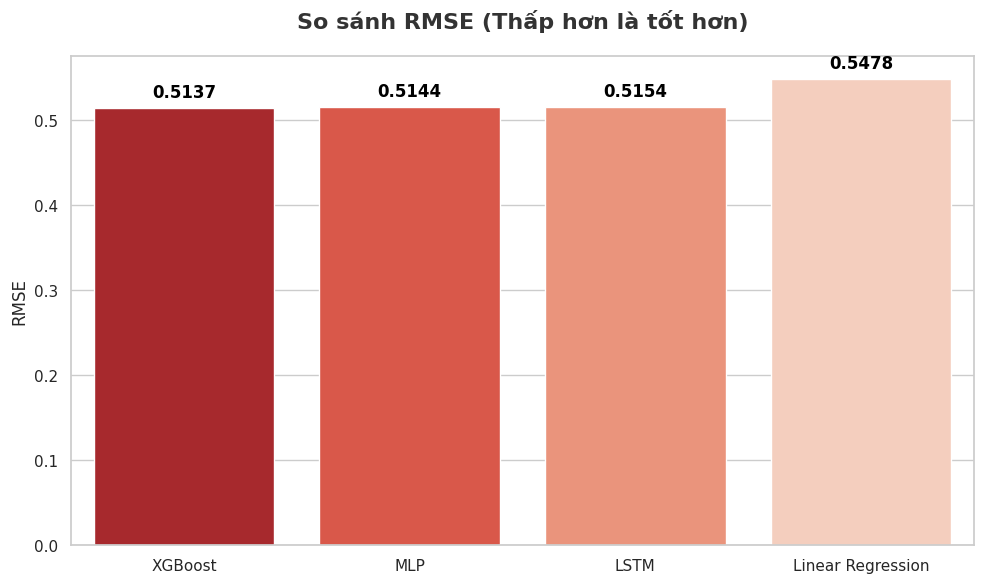

In [101]:
print("--- BIỂU ĐỒ 1: RMSE ---")
draw_bar_chart("RMSE", "So sánh RMSE (Thấp hơn là tốt hơn)", "Reds_r")

--- BIỂU ĐỒ 2: MAE ---


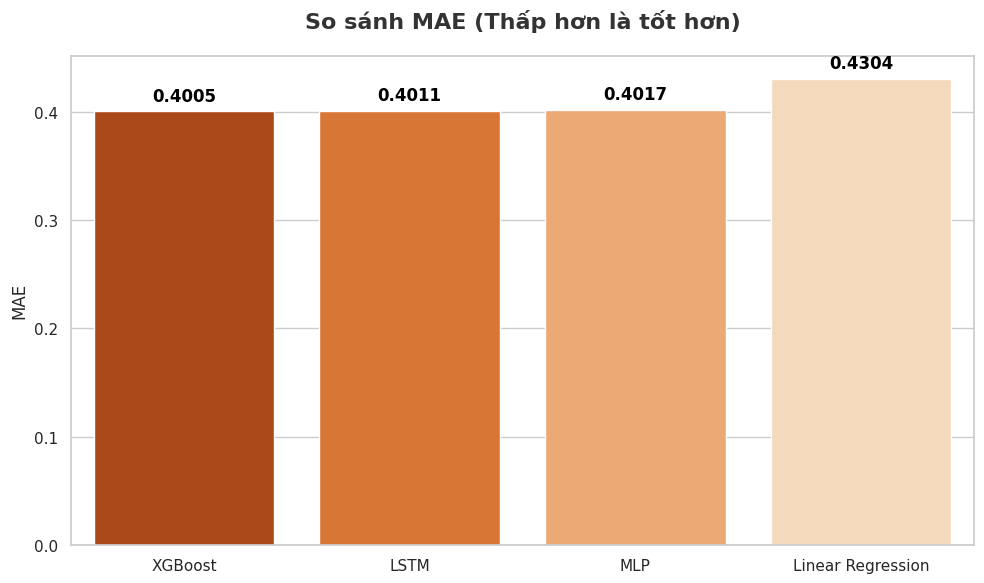

In [102]:
print("--- BIỂU ĐỒ 2: MAE ---")
draw_bar_chart("MAE", "So sánh MAE (Thấp hơn là tốt hơn)", "Oranges_r")

--- BIỂU ĐỒ 3: R-Squared ---


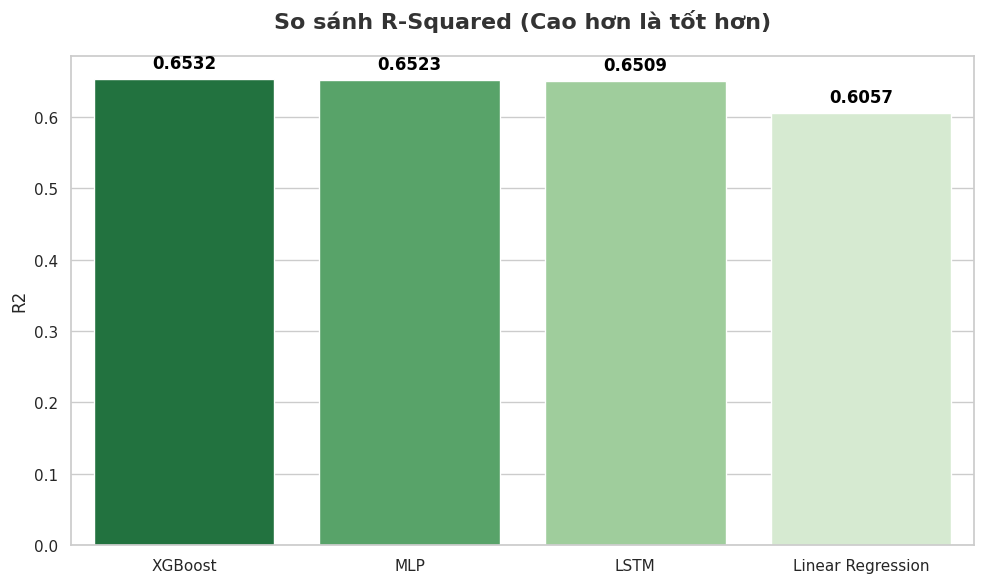

In [104]:
print("--- BIỂU ĐỒ 3: R-Squared ---")
draw_bar_chart("R2", "So sánh R-Squared (Cao hơn là tốt hơn)", "Greens_r")